In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
orderproducts = pd.read_csv('../data-raw/orderproducts.csv', parse_dates=[1,11], infer_datetime_format=True)
orderproducts.head()

,order_id,order_created_at,order_total_price,order_status,order_discounts,product_title,product_sku,product_quantity,product_discount,product_category,product_deparments,product_created_at
0,20570,2018-01-01 17:24:47+00:00,449.97,fulfilled,yes,Vertigo™ Semi-Hollow,M80-VHB-BLK,1,0.00,Electric Guitar Cases & Gig Bags,NaN,2017-10-26 02:57:14+00:00
1,20570,2018-01-01 17:24:47+00:00,449.97,fulfilled,yes,The Tick™ 2.0 Black,M80-TICK-V2-BLK,1,0.00,Pedals & Pedalboards Cases & Gig Bags,NaN,2017-10-26 02:57:14+00:00
2,20570,2018-01-01 17:24:47+00:00,449.97,fulfilled,yes,Pedalboard Lite (Silver),PFX-PB-LT-SLV,1,0.00,Pedalboards,NaN,2017-10-26 02:57:14+00:00
3,20556,2018-01-02 10:56:19+00:00,249.99,fulfilled,yes,Vertigo™ Semi-Hollow,M80-VHB-BLK,1,0.00,Electric Guitar Cases & Gig Bags,NaN,2017-10-26 02:57:14+00:00
4,20554,2018-01-02 11:45:26+00:00,NaN,fulfilled,no,The FlyBy,EFX-FLY-BLK,1,229.99,DJ Equipment Cases & Gig Bags,NaN,2017-10-26 02:57:14+00:00


In [3]:
products = pd.read_csv('../data-raw/products.csv')
products.head()

,id,title,sku,price_usd,category,tags,created_at
0,33184,"MONO Classic Acoustic/Dreadnought Guitar Case,...",M80-AD-BLK,229.99,Acoustic Guitar Cases & Gig Bags,Cases & Gig Bags,2017-10-26T02:57:14.000Z
1,33186,"MONO Vertigo Electric Guitar Case, Black",M80-VEG-BLK,249.99,Electric Guitar Cases & Gig Bags,Cases & Gig Bags,2017-10-26T02:57:14.000Z
2,33187,"MONO Classic Electric Guitar Case, Black",M80-EG-BLK,229.99,Electric Guitar Cases & Gig Bags,Cases & Gig Bags,2017-10-26T02:57:14.000Z
3,34589,"MONO Vertigo Electric Guitar Case, Grey",M80-VEG-GRY,249.99,Electric Guitar Cases & Gig Bags,Cases & Gig Bags,2017-10-26T02:57:14.000Z
4,34590,"MONO Vertigo Bass Guitar Case, Black",M80-VEB-BLK,249.99,Bass Guitar Cases & Gig Bags,Cases & Gig Bags,2017-10-26T02:57:14.000Z


#### Data Engineering

In [4]:
# Create date field, remove time details
orderproducts['order_date'] = [x.date() for x in orderproducts['order_created_at']]  # remove time, display only date
orderproducts['order_date'] = pd.to_datetime(orderproducts['order_date'])

In [5]:
# remove duplicated sku names
products = products.drop_duplicates(subset = ['sku'], keep='first')

In [6]:
# Extract the product price for individual item in the list
arr, emp = [], []
for i, row  in orderproducts.iterrows():
    if row.product_sku in list(products.sku):
        arr.append(float(products.loc[products['sku'] == row.product_sku, 'price_usd']))
    else:
        emp.append(row.product_sku)
        arr.append(0)
orderproducts['product_price'] = pd.DataFrame(arr)

In [7]:
# list of product skus that is not listed in products.csv
print(set(emp))

{nan, 'B-M80-AC-BLK', 'SRB-L-BLK', 'B-M80-EB-BLK', 'B-M80-VEG-GRY', 'CPN-BAG-STRAP-DPS-BLK', 'STICKER', 'B-M80-SAD-BLK', '50-K61-FOAM'}


In [8]:
orderproducts = orderproducts[['order_id', 'order_date', 'order_total_price', 'product_price', 'order_discounts',
                               'product_discount', 'order_status', 'product_title', 'product_sku', 'product_quantity',
                               'product_category']]
product_sku = orderproducts.groupby(['product_sku'])['product_quantity'].agg(['sum']).sort_values('sum', ascending=False).reset_index()

In [9]:
product_sku = orderproducts.groupby(['product_sku'])['product_quantity'].agg(['sum']).sort_values('sum', ascending=False).reset_index()

In [10]:
# filter orders where product_sku is in top 20 list
top_20 = list(product_sku['product_sku'].values)[0:20]
df = orderproducts[orderproducts['product_sku'].isin(top_20)]
df.set_index('order_date', inplace=True)

##### Plotting across months for the top 20 product skus

In [11]:
prod_monthly = pd.crosstab(df.index, df['product_sku']).resample('M').sum()
x_labels = list(prod_monthly.index.strftime('%Y-%m').values)

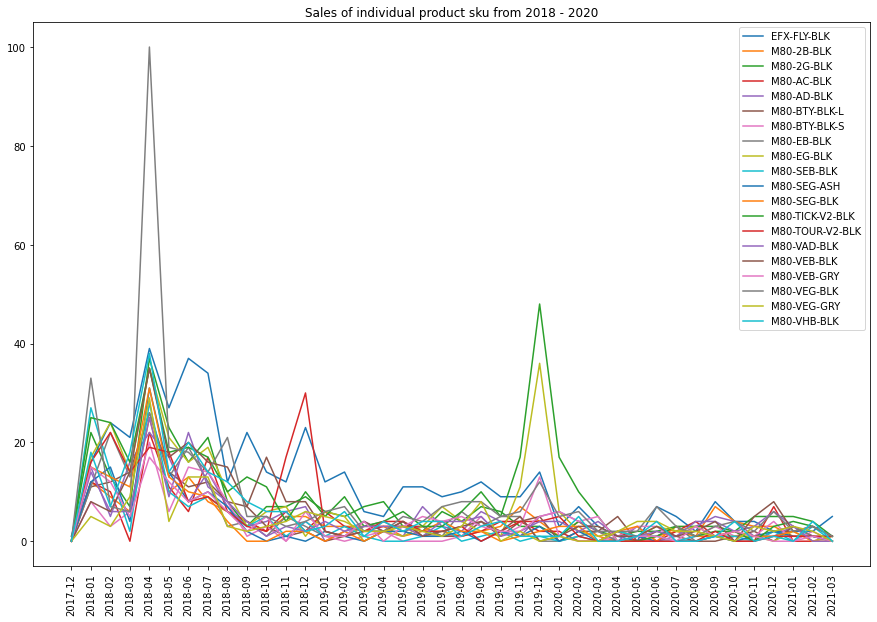

In [12]:
plt.figure(figsize=(15,10))
for prod in list(prod_monthly.columns):
    plt.plot(x_labels, prod_monthly[prod], label=prod)
plt.title('Sales of individual product sku from 2018 - 2020')
plt.xticks(np.arange(len(x_labels)),x_labels, rotation=90)
plt.legend(loc='upper right')
plt.show()

#### There are seasonal trends like in Apr, June, Sep and Dec where sales tend to peak

##### Plotting top 20 product skus across 2018, 2019 and 2020

In [13]:
prod_yearly = pd.crosstab(df.index, df['product_sku']).resample('Y').sum()

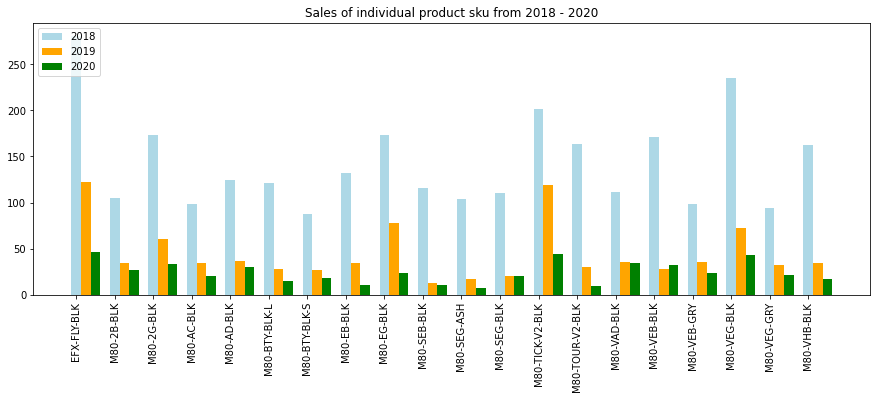

In [14]:
plt.figure(figsize=(15,5))
y_pos = np.arange(len(prod_yearly.columns))
plt.bar(y_pos+0,    prod_yearly.iloc[1,:].values, width=0.25, color = 'lightblue')
plt.bar(y_pos+0.25, prod_yearly.iloc[2,:].values, width=0.25, color = 'orange')
plt.bar(y_pos+0.50, prod_yearly.iloc[3,:].values, width=0.25, color = 'green')
plt.legend(["2018", "2019", "2020"], loc="upper left")
plt.title('Sales of individual product sku from 2018 - 2020')
plt.xticks(y_pos, prod_yearly.columns)
plt.xticks(rotation=90)
plt.show()